In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product, permutations, combinations
from zipfile import ZipFile
import requests
import glob
plt.style.use('ggplot')

Download data

In [ ]:
# url = "https://www.dropbox.com/sh/nuh41xq2rjhk57j/AAATuuSViRhoD44t-bkIT0oFa?dl=1"
# r = requests.get(url, allow_redirects=True)
# open('/content/evaluation_data.zip', 'wb').write(r.content)

815491

Extract files

In [ ]:
# with ZipFile('/content/evaluation_data.zip', 'r') as z:
#     # printing all the contents of the zip file
#     z.printdir()
#     # extracting all the files
#     print('Extracting all the files now...')
#     z.extractall()
#     print('Done!')

File Name                                             Modified             Size
/                                              2022-03-14 16:18:56            0
all_levels_BAS_L3.csv                          2022-02-18 01:33:38        84509
all_levels_BAS_L4.csv                          2022-02-18 01:30:00       108014
all_levels_BAS_L5.csv                          2022-02-18 01:24:20       203433
all_levels_NMI_L3.csv                          2022-02-18 01:33:56        24190
all_levels_NMI_L4.csv                          2022-02-18 01:29:52        24207
all_levels_NMI_L5.csv                          2022-02-18 01:21:12        37652
all_levels_SSM_L3.csv                          2022-02-18 01:34:16        67128
all_levels_SSM_L4.csv                          2022-02-18 01:31:48        90139
all_levels_SSM_L5.csv                          2022-02-18 01:24:02       174913
Extracting all the files now...
Done!


Get all NMI evaluation data into a single dataframe and melt it

In [2]:
nmi_files = glob.glob("../data/Data_frames/*NMI*")
nmi_levels = [s.split("_")[-1].split(".")[0][-1] for s in nmi_files]
nmi_df = []
for f,l in zip(nmi_files,nmi_levels):
  df = pd.read_csv(f)
  df['Number of levels'] = l
  nmi_df.append(df)
nmi_df = (pd.concat(nmi_df)
          .melt(id_vars=['algorithm', 'Number of levels'], value_vars=['NMI'])
          .rename({'algorithm': 'Algorithm',
                   'value': 'NMI'}, axis=1))
nmi_df

,Algorithm,Number of levels,variable,NMI
0,Natural_C,5,NMI,0.438877
1,Natural_C,5,NMI,0.556069
2,Natural_C,5,NMI,0.446900
3,Natural_C,5,NMI,0.585844
4,Natural_C,5,NMI,0.472614
...,...,...,...,...
1825,Adap_DBSCAN,3,NMI,0.665785
1826,Adap_DBSCAN,3,NMI,0.564085
1827,Adap_DBSCAN,3,NMI,0.639567
1828,Adap_DBSCAN,3,NMI,0.400680


Barplots for all number of levels


<AxesSubplot:xlabel='Algorithm', ylabel='NMI'>

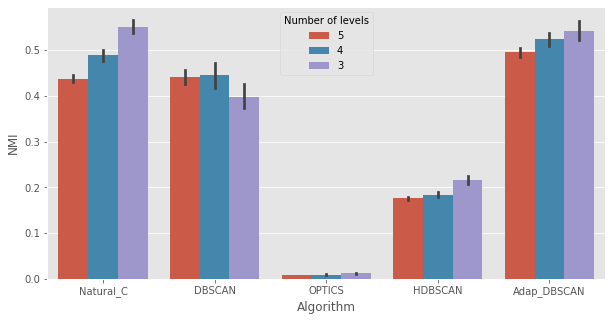

In [3]:
plt.figure(figsize=(10,5))
sns.barplot(x="Algorithm", y="NMI", hue="Number of levels", data=nmi_df)

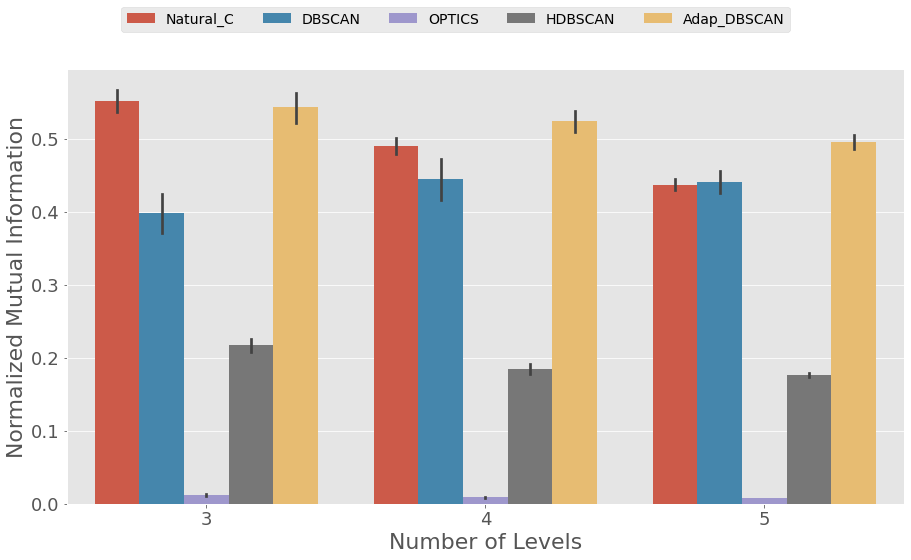

In [49]:
fig, axs = plt.subplots( figsize=(15, 8))

# plt.figure(figsize=(16,5))
sns.barplot(x="Number of levels", y="NMI", hue="Algorithm", data=nmi_df, order=["3", "4", "5"], ax= axs)
axs.get_legend().remove()
axs.tick_params(axis='both', labelsize=18)
axs.set_ylabel('Normalized Mutual Information', fontsize = 22)
axs.set_xlabel('Number of Levels', fontsize = 22)
fig.legend(loc='upper center',
           ncol=5,
           fontsize=14,
           # bbox_to_anchor=(5, .5),
          )
plt.savefig("../output/NMI.pdf", dpi=600,  bbox_inches='tight')

## Pairwise Welch test

In [27]:
algos = nmi_df.Algorithm.unique()
pairs = list(combinations(algos, 2))
welchs = []
for l in nmi_df["Number of levels"].unique():
  level = []
  for a1, a2 in pairs:
    if a1 != a2:
      w = ttest_ind(nmi_df.loc[(nmi_df['Algorithm'] == a1) & (nmi_df['Number of levels'] == l)]['NMI'].values, 
                    nmi_df.loc[(nmi_df['Algorithm'] == a2) & (nmi_df['Number of levels'] == l)]['NMI'].values, 
                    equal_var=False)
      level.append({'Comparisson': f'{a1} Vs {a2}' ,'Welch test': round(w.statistic, 2), "p-value": round(w.pvalue, 2)})
  welchs.append(pd.DataFrame(level))
welchs = pd.concat([w.set_index('Comparisson') for w in welchs], axis=1)
iterables = [["3", "4", "5"], ["Welch test", "p-value"]]
welchs.columns = pd.MultiIndex.from_product(iterables, names=["Number of Levels", "Statistics"])
welchs

Number of Levels                  3                  4                  5  \
Statistics               Welch test p-value Welch test p-value Welch test   
Comparisson                                                                 
Natural_C Vs DBSCAN           -0.46    0.64       2.89     0.0       9.37   
Natural_C Vs OPTICS          108.72    0.00      79.07     0.0      68.45   
Natural_C Vs HDBSCAN          60.97    0.00      44.71     0.0      36.48   
Natural_C Vs Adap_DBSCAN      -9.08    0.00      -3.54     0.0       0.63   
DBSCAN Vs OPTICS              54.59    0.00      30.91     0.0      27.14   
DBSCAN Vs HDBSCAN             32.65    0.00      18.06     0.0      12.12   
DBSCAN Vs Adap_DBSCAN         -5.77    0.00      -4.92     0.0      -8.08   
OPTICS Vs HDBSCAN           -102.13    0.00     -55.77     0.0     -43.45   
OPTICS Vs Adap_DBSCAN        -95.49    0.00     -67.92     0.0     -49.31   
HDBSCAN Vs Adap_DBSCAN       -59.50    0.00     -41.45     0.0     -27.76   

Number of Levels                  
Statistics               p-value  
Comparisson                       
Natural_C Vs DBSCAN         0.00  
Natural_C Vs OPTICS         0.00  
Natural_C Vs HDBSCAN        0.00  
Natural_C Vs Adap_DBSCAN    0.53  
DBSCAN Vs OPTICS            0.00  
DBSCAN Vs HDBSCAN           0.00  
DBSCAN Vs Adap_DBSCAN       0.00  
OPTICS Vs HDBSCAN           0.00  
OPTICS Vs Adap_DBSCAN       0.00  
HDBSCAN Vs Adap_DBSCAN      0.00

In [29]:
welchs.reset_index().to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n             Comparisson & \\multicolumn{2}{l}{3} & \\multicolumn{2}{l}{4} & \\multicolumn{2}{l}{5} \\\\\n                         & Welch test & p-value & Welch test & p-value & Welch test & p-value \\\\\n\\midrule\n     Natural\\_C Vs DBSCAN &      -0.46 &    0.64 &       2.89 &     0.0 &       9.37 &    0.00 \\\\\n     Natural\\_C Vs OPTICS &     108.72 &    0.00 &      79.07 &     0.0 &      68.45 &    0.00 \\\\\n    Natural\\_C Vs HDBSCAN &      60.97 &    0.00 &      44.71 &     0.0 &      36.48 &    0.00 \\\\\nNatural\\_C Vs Adap\\_DBSCAN &      -9.08 &    0.00 &      -3.54 &     0.0 &       0.63 &    0.53 \\\\\n        DBSCAN Vs OPTICS &      54.59 &    0.00 &      30.91 &     0.0 &      27.14 &    0.00 \\\\\n       DBSCAN Vs HDBSCAN &      32.65 &    0.00 &      18.06 &     0.0 &      12.12 &    0.00 \\\\\n   DBSCAN Vs Adap\\_DBSCAN &      -5.77 &    0.00 &      -4.92 &     0.0 &      -8.08 &    0.00 \\\\\n       OPTICS Vs HDBSCAN &    -1

In [ ]:
a.reset_index().to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\nNumber of Levels &               Comparisson & \\multicolumn{2}{l}{3} & \\multicolumn{2}{l}{4} & \\multicolumn{2}{l}{5} \\\\\nStatistics &  Welch test &        p-value & Welch test &       p-value & Welch test &       p-value \\\\\n\\midrule\n0  &       Natural\\_C Vs DBSCAN &   -0.462191 &   6.443863e-01 &   2.889792 &  4.463815e-03 &   9.374123 &  5.930234e-17 \\\\\n1  &       Natural\\_C Vs OPTICS &  108.718049 &  1.262494e-148 &  79.070305 &  4.556763e-95 &  68.446779 &  9.726230e-89 \\\\\n2  &      Natural\\_C Vs HDBSCAN &   60.973112 &  2.517520e-134 &  44.710059 &  1.070219e-90 &  36.477760 &  2.918386e-82 \\\\\n3  &  Natural\\_C Vs Adap\\_DBSCAN &   -9.077571 &   1.716227e-17 &  -3.543001 &  4.930972e-04 &   0.625629 &  5.323074e-01 \\\\\n4  &       DBSCAN Vs Natural\\_C &    0.462191 &   6.443863e-01 &  -2.889792 &  4.463815e-03 &  -9.374123 &  5.930234e-17 \\\\\n5  &          DBSCAN Vs OPTICS &   54.589169 &  3.547847e-103 &  30.911688 

In [ ]:
list(combinations(algos, 2))

[('Natural_C', 'DBSCAN'),
 ('Natural_C', 'OPTICS'),
 ('Natural_C', 'HDBSCAN'),
 ('Natural_C', 'Adap_DBSCAN'),
 ('DBSCAN', 'OPTICS'),
 ('DBSCAN', 'HDBSCAN'),
 ('DBSCAN', 'Adap_DBSCAN'),
 ('OPTICS', 'HDBSCAN'),
 ('OPTICS', 'Adap_DBSCAN'),
 ('HDBSCAN', 'Adap_DBSCAN')]

# Balanced Acuracy

Using the data we need to do one for each level of experiments 


In [47]:
bas_levels

['5', '4', '3']

In [32]:
bas_files = glob.glob("../data/Data_frames/*BAS*")
bas_levels = [s.split("_")[-1].split(".")[0][-1] for s in nmi_files]
bas_df = []
for f,l in zip(bas_files,bas_levels):
    df = pd.read_csv(f)
    df['Number of levels'] = l
    bas_df.append(df)
    
bas_df = (pd.concat(bas_df)
          .melt(id_vars=['algorithm', 'Number of levels'], value_vars=['BAS'])
          .rename({'algorithm': 'Algorithm',
                   'value': 'BAS'}, axis=1))
bas_df

,Algorithm,Number of levels,variable,BAS
0,Natural_C,5,BAS,0.965388
1,Natural_C,5,BAS,0.884940
2,Natural_C,5,BAS,0.853435
3,Natural_C,5,BAS,0.500000
4,Natural_C,5,BAS,0.985628
...,...,...,...,...
9400,Adap_DBSCAN,3,BAS,0.985288
9401,Adap_DBSCAN,3,BAS,0.970695
9402,Adap_DBSCAN,3,BAS,0.833263
9403,Adap_DBSCAN,3,BAS,0.816131


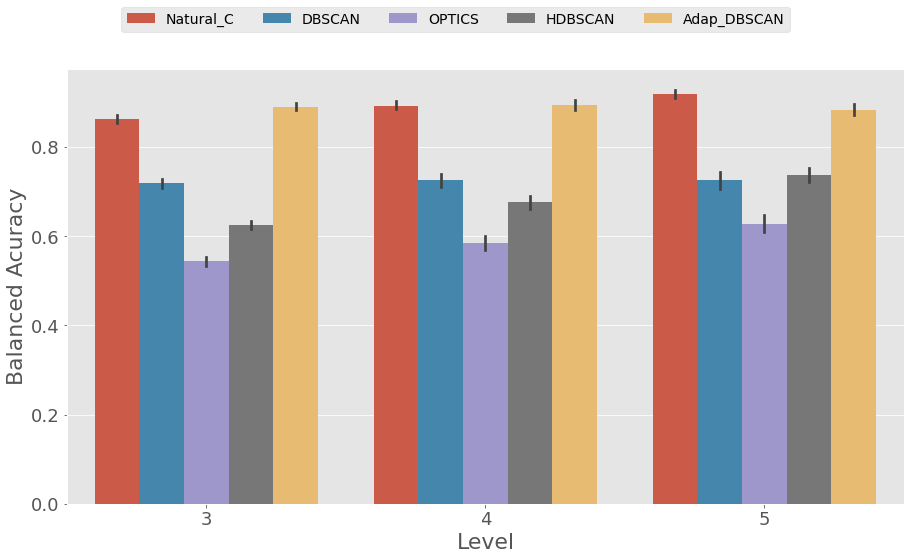

In [39]:
fig, axs = plt.subplots( figsize=(15, 8))

# plt.figure(figsize=(16,5))
sns.barplot(x="Number of levels", y="BAS", hue="Algorithm", data=bas_df, order=["3", "4", "5"], ax= axs)
axs.get_legend().remove()
axs.tick_params(axis='both', labelsize=18)
axs.set_ylabel('Balanced Acuracy', fontsize = 22)
axs.set_xlabel('Level', fontsize = 22)
fig.legend(loc='upper center',
           ncol=5,
           fontsize=14,
           # bbox_to_anchor=(5, .5),
          )

In [37]:
algos = bas_df.Algorithm.unique()
pairs = list(combinations(algos, 2))
welchs_bas = []
for l in bas_df["Number of levels"].unique():
    level = []
    for a1, a2 in pairs:
        if a1 != a2:
            w = ttest_ind(bas_df.loc[(bas_df['Algorithm'] == a1) & (bas_df['Number of levels'] == l)]['BAS'].values, 
                    bas_df.loc[(bas_df['Algorithm'] == a2) & (bas_df['Number of levels'] == l)]['BAS'].values, 
                    equal_var=False)
            level.append({'Comparisson': f'{a1} Vs {a2}' ,'Welch test': round(w.statistic, 2), "p-value": round(w.pvalue, 2)})
    welchs_bas.append(pd.DataFrame(level))
welchs_bas = pd.concat([w.set_index('Comparisson') for w in welchs_bas], axis=1)
iterables = [["3", "4", "5"], ["Welch test", "p-value"]]
welchs_bas.columns = pd.MultiIndex.from_product(iterables, names=["Number of Levels", "Statistics"])
welchs_bas

Number of Levels                  3                  4                  5  \
Statistics               Welch test p-value Welch test p-value Welch test   
Comparisson                                                                 
Natural_C Vs DBSCAN           18.73    0.00      18.49    0.00      21.07   
Natural_C Vs OPTICS           26.40    0.00      32.59    0.00      48.38   
Natural_C Vs HDBSCAN          19.93    0.00      24.72    0.00      36.39   
Natural_C Vs Adap_DBSCAN       4.44    0.00      -0.08    0.94      -4.60   
DBSCAN Vs OPTICS               7.18    0.00      12.58    0.00      23.73   
DBSCAN Vs HDBSCAN             -0.93    0.35       4.65    0.00      12.83   
DBSCAN Vs Adap_DBSCAN        -14.09    0.00     -17.73    0.00     -24.94   
OPTICS Vs HDBSCAN             -8.56    0.00      -8.34    0.00     -11.40   
OPTICS Vs Adap_DBSCAN        -21.55    0.00     -31.31    0.00     -52.15   
HDBSCAN Vs Adap_DBSCAN       -14.49    0.00     -23.61    0.00     -40.29   

Number of Levels                  
Statistics               p-value  
Comparisson                       
Natural_C Vs DBSCAN          0.0  
Natural_C Vs OPTICS          0.0  
Natural_C Vs HDBSCAN         0.0  
Natural_C Vs Adap_DBSCAN     0.0  
DBSCAN Vs OPTICS             0.0  
DBSCAN Vs HDBSCAN            0.0  
DBSCAN Vs Adap_DBSCAN        0.0  
OPTICS Vs HDBSCAN            0.0  
OPTICS Vs Adap_DBSCAN        0.0  
HDBSCAN Vs Adap_DBSCAN       0.0

In [48]:
bas_files = glob.glob("../data/Data_frames/*BAS*")
bas_levels = [s.split("_")[-1].split(".")[0][-1] for s in nmi_files]
bas_df = []
for f,l in zip(bas_files,bas_levels):
    df = pd.read_csv(f)
    df['Number of levels'] = l
    bas_df.append(df)
    
bas_df = (pd.concat(bas_df)
          .melt(id_vars=['algorithm', 'Number of levels', 'Level'], value_vars=['BAS'])
          .rename({'algorithm': 'Algorithm',
                   'value': 'BAS'}, axis=1))
bas_df

,Algorithm,Number of levels,Level,variable,BAS
0,Natural_C,5,0,BAS,0.965388
1,Natural_C,5,1,BAS,0.884940
2,Natural_C,5,2,BAS,0.853435
3,Natural_C,5,3,BAS,0.500000
4,Natural_C,5,0,BAS,0.985628
...,...,...,...,...,...
9400,Adap_DBSCAN,3,1,BAS,0.985288
9401,Adap_DBSCAN,3,2,BAS,0.970695
9402,Adap_DBSCAN,3,3,BAS,0.833263
9403,Adap_DBSCAN,3,4,BAS,0.816131


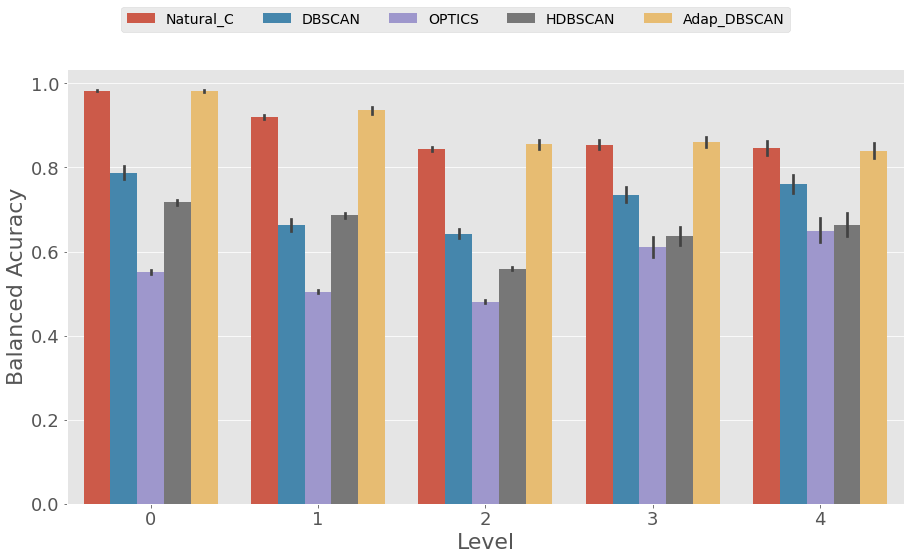

In [53]:
fig, axs = plt.subplots( figsize=(15, 8))

# plt.figure(figsize=(16,5))
sns.barplot(x="Level", y="BAS", hue="Algorithm", data=bas_df, order=[0,1,2,3,4], ax= axs)
axs.get_legend().remove()
axs.tick_params(axis='both', labelsize=18)
axs.set_ylabel('Balanced Acuracy', fontsize = 22)
axs.set_xlabel('Level', fontsize = 22)
fig.legend(loc='upper center',
           ncol=5,
           fontsize=14,
           # bbox_to_anchor=(5, .5),
          )

In [79]:
algos = bas_df.Algorithm.unique()
pairs = list(combinations(algos, 2))
welchs_bas = []
for l in bas_df["Level"].unique():
    level = []
    for a1, a2 in pairs:
        if a1 != a2:
            w = ttest_ind(bas_df.loc[(bas_df['Algorithm'] == a1) & (bas_df['Level'] == l)]['BAS'].values, 
                    bas_df.loc[(bas_df['Algorithm'] == a2) & (bas_df['Level'] == l)]['BAS'].values, 
                    equal_var=False)
            level.append({'Comparisson': f'{a1} Vs {a2}', 'Level':l, 'Welch test': round(w.statistic, 2), "p-value": round(w.pvalue, 2)})
    welchs_bas.append(level)
# welchs_bas = pd.concat([w.set_index('Comparisson') for w in welchs_bas], axis=1)
# iterables = [[0,1,2,3,4,5], ["Welch test", "p-value"]]
# welchs_bas.columns = pd.MultiIndex.from_product(iterables, names=["Level", "Statistics"])
# welchs_bas

In [80]:
iterables = [[0,1,2,3,4,5], ["Welch test", "p-value"]]
welchs_bas_mul_col = pd.MultiIndex.from_product(iterables, names=["Level", "Statistics"])
welchs_bas_mul_col

MultiIndex([(0, 'Welch test'),
            (0,    'p-value'),
            (1, 'Welch test'),
            (1,    'p-value'),
            (2, 'Welch test'),
            (2,    'p-value'),
            (3, 'Welch test'),
            (3,    'p-value'),
            (4, 'Welch test'),
            (4,    'p-value'),
            (5, 'Welch test'),
            (5,    'p-value')],
           names=['Level', 'Statistics'])

In [89]:
pd.DataFrame(welchs_bas)#,index= 'Comparisson', columns=welchs_bas_mul_col)

ValueError: Must pass 2-d input. shape=(6, 10, 4)

# Similarity Shape Measure

In [41]:
ssm_files = glob.glob("../data/Data_frames/*SSM*")
ssm_levels = [s.split("_")[-1].split(".")[0][-1] for s in nmi_files]
ssm_df = []
for f,l in zip(ssm_files,ssm_levels):
    df = pd.read_csv(f)
    df['Number of levels'] = l
    ssm_df.append(df)
    
ssm_df = (pd.concat(ssm_df)
          .melt(id_vars=['algorithm', 'Number of levels'], value_vars=['SSM'])
          .rename({'algorithm': 'Algorithm',
                   'value': 'SSM'}, axis=1))
ssm_df

,Algorithm,Number of levels,variable,SSM
0,Natural,5,SSM,0.843900
1,Natural,5,SSM,0.094370
2,Natural,5,SSM,0.000033
3,Natural,5,SSM,0.001834
4,Natural,5,SSM,0.001793
...,...,...,...,...
7570,Adap_DBSCAN,3,SSM,0.529553
7571,Adap_DBSCAN,3,SSM,0.804887
7572,Adap_DBSCAN,3,SSM,0.245013
7573,Adap_DBSCAN,3,SSM,0.338984


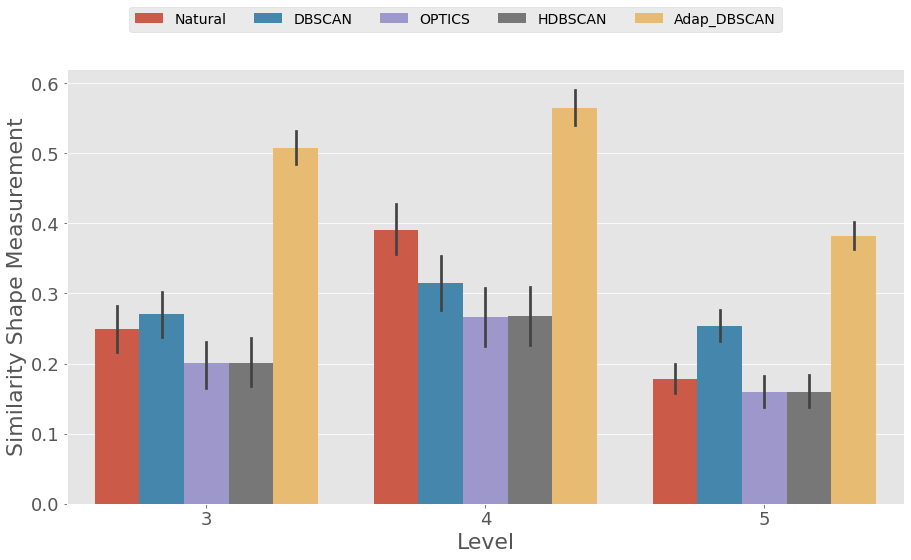

In [42]:
fig, axs = plt.subplots( figsize=(15, 8))

# plt.figure(figsize=(16,5))
sns.barplot(x="Number of levels", y="SSM", hue="Algorithm", data=ssm_df, order=["3", "4", "5"], ax= axs)
axs.get_legend().remove()
axs.tick_params(axis='both', labelsize=18)
axs.set_ylabel('Similarity Shape Measurement', fontsize = 22)
axs.set_xlabel('Level', fontsize = 22)
fig.legend(loc='upper center',
           ncol=5,
           fontsize=14,
           # bbox_to_anchor=(5, .5),
          )

In [43]:
bas_files = glob.glob("../data/Data_frames/*BAS*")
bas_levels = [s.split("_")[-1].split(".")[0][-1] for s in nmi_files]
bas_df = []
for f,l in zip(bas_files,bas_levels):
    df = pd.read_csv(f)
    df['Number of levels'] = l
    bas_df.append(df)
    
bas_df = (pd.concat(bas_df)
          .melt(id_vars=['algorithm', 'Number of levels'], value_vars=['BAS'])
          .rename({'algorithm': 'Algorithm',
                   'value': 'BAS'}, axis=1))
bas_df

,Algorithm,Number of levels,variable,BAS
0,Natural_C,5,BAS,0.965388
1,Natural_C,5,BAS,0.884940
2,Natural_C,5,BAS,0.853435
3,Natural_C,5,BAS,0.500000
4,Natural_C,5,BAS,0.985628
...,...,...,...,...
9400,Adap_DBSCAN,3,BAS,0.985288
9401,Adap_DBSCAN,3,BAS,0.970695
9402,Adap_DBSCAN,3,BAS,0.833263
9403,Adap_DBSCAN,3,BAS,0.816131
